In [2]:

# Import libraries and modules
import numpy as np
np.random.seed(123)  # for reproducibility
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, Bidirectional
from keras.layers import Dropout
from keras.layers import Flatten, TimeDistributed, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras import metrics
from keras import backend
from numpy import argmax
from numpy import asarray
from pylab import rcParams
from sklearn.metrics import confusion_matrix
rcParams['figure.figsize'] = 15, 10

def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis = -1))

def sensitivity(y_true, y_pred):  
     y_pred_pos = backend.round(backend.clip(y_pred, 0, 1))
     y_pred_neg = 1 - y_pred_pos
     y_pos = backend.round(backend.clip(y_true, 0, 1))
     y_neg = 1 - y_pos
     tp = backend.sum(y_pos * y_pred_pos)
     tn = backend.sum(y_neg * y_pred_neg)
     fp = backend.sum(y_neg * y_pred_pos)
     fn = backend.sum(y_pos * y_pred_neg)
     sensitivity = tp / (tp + fn)
     return sensitivity

# Recall is the same as the sensitivity
def recall(y_true, y_pred):  
     y_pred_pos = backend.round(backend.clip(y_pred, 0, 1))
     y_pred_neg = 1 - y_pred_pos
     y_pos = backend.round(backend.clip(y_true, 0, 1))
     y_neg = 1 - y_pos
     tp = backend.sum(y_pos * y_pred_pos)
     tn = backend.sum(y_neg * y_pred_neg)
     fp = backend.sum(y_neg * y_pred_pos)
     fn = backend.sum(y_pos * y_pred_neg)
     recall = tp / (tp + fn)
     return recall

def specificity(y_true, y_pred):  
     y_pred_pos = backend.round(backend.clip(y_pred, 0, 1))
     y_pred_neg = 1 - y_pred_pos
     y_pos = backend.round(backend.clip(y_true, 0, 1))
     y_neg = 1 - y_pos
     tp = backend.sum(y_pos * y_pred_pos)
     tn = backend.sum(y_neg * y_pred_neg)
     fp = backend.sum(y_neg * y_pred_pos)
     fn = backend.sum(y_pos * y_pred_neg)
     specificity = tn / (tn + fp)
     return specificity


def precision(y_true, y_pred):  
     y_pred_pos = backend.round(backend.clip(y_pred, 0, 1))
     y_pred_neg = 1 - y_pred_pos
     y_pos = backend.round(backend.clip(y_true, 0, 1))
     y_neg = 1 - y_pos
     tp = backend.sum(y_pos * y_pred_pos)
     tn = backend.sum(y_neg * y_pred_neg)
     fp = backend.sum(y_neg * y_pred_pos)
     fn = backend.sum(y_pos * y_pred_neg)
     precision = tp / (tp + fp)
     return precision


#(A) 3 class classification [AB vs CD vs E]

In [3]:
df=pd.read_csv("/content/drive/My Drive/mtech_finalyr_project/modified_Dataset/final_csv_with_shuffle_ABvsCDvsE.csv")
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4057,4058,4059,4060,4061,4062,4063,4064,4065,4066,4067,4068,4069,4070,4071,4072,4073,4074,4075,4076,4077,4078,4079,4080,4081,4082,4083,4084,4085,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095,tag
0,-18.0,-55.0,-126.0,-202.0,-238.0,-226.0,-171.0,-111.0,-73.0,-48.0,-45.0,-53.0,-95.0,-165.0,-243.0,-288.0,-309.0,-237.0,-95.0,163.0,528.0,899.0,1179.0,1316.0,1283.0,1132.0,907.0,672.0,338.0,-112.0,-340.0,-430.0,-38.0,293.0,379.0,178.0,-148.0,-375.0,-415.0,-399.0,...,230.0,180.0,-125.0,48.0,204.0,747.0,1153.0,1183.0,949.0,534.0,153.0,-83.0,-168.0,-208.0,-250.0,-246.0,-235.0,-224.0,-244.0,-275.0,-305.0,-334.0,-368.0,-394.0,-406.0,-398.0,-361.0,-309.0,-225.0,-129.0,-59.0,-48.0,-94.0,-161.0,-210.0,-222.0,-224.0,-200.0,-127.0,4
1,-26.0,1.0,29.0,41.0,33.0,2.0,-31.0,-60.0,-81.0,-99.0,-117.0,-140.0,-168.0,-200.0,-242.0,-280.0,-313.0,-339.0,-350.0,-345.0,-323.0,-292.0,-271.0,-269.0,-292.0,-354.0,-487.0,-682.0,-747.0,-635.0,-330.0,5.0,208.0,313.0,335.0,348.0,358.0,423.0,474.0,456.0,...,-411.0,-423.0,-366.0,-229.0,-79.0,40.0,126.0,195.0,242.0,307.0,395.0,504.0,592.0,656.0,696.0,701.0,659.0,545.0,368.0,196.0,80.0,48.0,73.0,93.0,75.0,5.0,-101.0,-204.0,-279.0,-308.0,-288.0,-254.0,-220.0,-200.0,-201.0,-205.0,-209.0,-207.0,-210.0,4
2,68.0,-106.0,-149.0,-141.0,-109.0,-69.0,-74.0,-93.0,-110.0,-103.0,-89.0,-72.0,-42.0,-18.0,5.0,24.0,50.0,74.0,93.0,110.0,118.0,120.0,118.0,118.0,114.0,108.0,100.0,88.0,71.0,57.0,39.0,20.0,7.0,10.0,40.0,95.0,173.0,240.0,239.0,164.0,...,-30.0,244.0,364.0,262.0,-6.0,-319.0,-509.0,-501.0,-350.0,-150.0,-8.0,7.0,-30.0,-108.0,-183.0,-221.0,-182.0,-92.0,49.0,208.0,299.0,330.0,284.0,203.0,135.0,81.0,57.0,72.0,105.0,146.0,196.0,260.0,367.0,493.0,566.0,554.0,460.0,343.0,247.0,4
3,343.0,311.0,284.0,274.0,260.0,237.0,165.0,-33.0,-271.0,-425.0,-418.0,-254.0,-104.0,-14.0,16.0,24.0,23.0,11.0,4.0,20.0,40.0,67.0,99.0,127.0,130.0,126.0,133.0,124.0,108.0,54.0,-5.0,-45.0,-61.0,-65.0,-52.0,-46.0,-25.0,-15.0,-4.0,-12.0,...,2.0,-70.0,-118.0,-155.0,-201.0,-283.0,-368.0,-363.0,-333.0,-271.0,-203.0,-126.0,-31.0,48.0,86.0,102.0,124.0,125.0,132.0,144.0,187.0,263.0,343.0,411.0,433.0,417.0,397.0,395.0,414.0,435.0,439.0,428.0,423.0,430.0,472.0,515.0,527.0,480.0,397.0,4
4,-63.0,-107.0,-208.0,-310.0,-395.0,-491.0,-463.0,-426.0,-275.0,-114.0,34.0,142.0,191.0,183.0,141.0,103.0,76.0,66.0,74.0,95.0,110.0,127.0,136.0,141.0,141.0,137.0,118.0,89.0,42.0,6.0,-33.0,-52.0,-49.0,-31.0,-5.0,23.0,40.0,47.0,45.0,40.0,...,-616.0,-588.0,-534.0,-475.0,-405.0,-330.0,-281.0,-269.0,-296.0,-358.0,-393.0,-363.0,-251.0,-131.0,-57.0,-81.0,-156.0,-239.0,-318.0,-396.0,-372.0,-270.0,-71.0,66.0,75.0,7.0,-84.0,-148.0,-187.0,-263.0,-367.0,-495.0,-517.0,-432.0,-234.0,-32.0,56.0,44.0,-37.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,213.0,210.0,210.0,212.0,194.0,162.0,121.0,84.0,45.0,11.0,-13.0,-20.0,-27.0,-32.0,-31.0,-39.0,-49.0,-61.0,-72.0,-80.0,-85.0,-87.0,-93.0,-96.0,-97.0,-94.0,-82.0,-57.0,-18.0,-3.0,-11.0,-1.0,41.0,120.0,181.0,202.0,198.0,195.0,197.0,190.0,...,-110.0,-108.0,-112.0,-113.0,-112.0,-103.0,-100.0,-98.0,-95.0,-94.0,-92.0,-91.0,-89.0,-86.0,-84.0,-78.0,-70.0,-63.0,-53.0,-46.0,-37.0,-34.0,-29.0,-28.0,-23.0,-15.0,-13.0,-14.0,-9.0,-10.0,-5.0,-2.0,1.0,1.0,-2.0,-8.0,-9.0,-2.0,20.0,4
496,24.0,10.0,-9.0,-18.0,-9.0,-3.0,-2.0,-2.0,-9.0,-9.0,-14.0,-14.0,-24.0,-24.0,-12.0,-1.0,13.0,31.0,60.0,79.0,98.0,110.0,104.0,72.0,40.0,26.0,24.0,33.0,40.0,29.0,13.0,3.0,2.0,0.0,10.0,32.0,52.0,61.0,54.0,19.0,...,73.0,55.0,33.0,15.0,-5.0,-18.0,-24.0,-28.0,-15.0,12.0,33.0,48.0,47.0,36.0,19.0,16.0,31.0,56.0,69.0,75.0,67.0,66.0,76.0,93.0,88.0,65.0,56.0,58.0,63.0,48.0,29.0,3.0,-17.0,-14.0,-21.0,-29.0,-3

In [4]:
#converting tags into 0 nd 1
df.tag=df.tag.replace({2:1 , 4:2 })
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4057,4058,4059,4060,4061,4062,4063,4064,4065,4066,4067,4068,4069,4070,4071,4072,4073,4074,4075,4076,4077,4078,4079,4080,4081,4082,4083,4084,4085,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095,tag
0,-18.0,-55.0,-126.0,-202.0,-238.0,-226.0,-171.0,-111.0,-73.0,-48.0,-45.0,-53.0,-95.0,-165.0,-243.0,-288.0,-309.0,-237.0,-95.0,163.0,528.0,899.0,1179.0,1316.0,1283.0,1132.0,907.0,672.0,338.0,-112.0,-340.0,-430.0,-38.0,293.0,379.0,178.0,-148.0,-375.0,-415.0,-399.0,...,230.0,180.0,-125.0,48.0,204.0,747.0,1153.0,1183.0,949.0,534.0,153.0,-83.0,-168.0,-208.0,-250.0,-246.0,-235.0,-224.0,-244.0,-275.0,-305.0,-334.0,-368.0,-394.0,-406.0,-398.0,-361.0,-309.0,-225.0,-129.0,-59.0,-48.0,-94.0,-161.0,-210.0,-222.0,-224.0,-200.0,-127.0,2
1,-26.0,1.0,29.0,41.0,33.0,2.0,-31.0,-60.0,-81.0,-99.0,-117.0,-140.0,-168.0,-200.0,-242.0,-280.0,-313.0,-339.0,-350.0,-345.0,-323.0,-292.0,-271.0,-269.0,-292.0,-354.0,-487.0,-682.0,-747.0,-635.0,-330.0,5.0,208.0,313.0,335.0,348.0,358.0,423.0,474.0,456.0,...,-411.0,-423.0,-366.0,-229.0,-79.0,40.0,126.0,195.0,242.0,307.0,395.0,504.0,592.0,656.0,696.0,701.0,659.0,545.0,368.0,196.0,80.0,48.0,73.0,93.0,75.0,5.0,-101.0,-204.0,-279.0,-308.0,-288.0,-254.0,-220.0,-200.0,-201.0,-205.0,-209.0,-207.0,-210.0,2
2,68.0,-106.0,-149.0,-141.0,-109.0,-69.0,-74.0,-93.0,-110.0,-103.0,-89.0,-72.0,-42.0,-18.0,5.0,24.0,50.0,74.0,93.0,110.0,118.0,120.0,118.0,118.0,114.0,108.0,100.0,88.0,71.0,57.0,39.0,20.0,7.0,10.0,40.0,95.0,173.0,240.0,239.0,164.0,...,-30.0,244.0,364.0,262.0,-6.0,-319.0,-509.0,-501.0,-350.0,-150.0,-8.0,7.0,-30.0,-108.0,-183.0,-221.0,-182.0,-92.0,49.0,208.0,299.0,330.0,284.0,203.0,135.0,81.0,57.0,72.0,105.0,146.0,196.0,260.0,367.0,493.0,566.0,554.0,460.0,343.0,247.0,2
3,343.0,311.0,284.0,274.0,260.0,237.0,165.0,-33.0,-271.0,-425.0,-418.0,-254.0,-104.0,-14.0,16.0,24.0,23.0,11.0,4.0,20.0,40.0,67.0,99.0,127.0,130.0,126.0,133.0,124.0,108.0,54.0,-5.0,-45.0,-61.0,-65.0,-52.0,-46.0,-25.0,-15.0,-4.0,-12.0,...,2.0,-70.0,-118.0,-155.0,-201.0,-283.0,-368.0,-363.0,-333.0,-271.0,-203.0,-126.0,-31.0,48.0,86.0,102.0,124.0,125.0,132.0,144.0,187.0,263.0,343.0,411.0,433.0,417.0,397.0,395.0,414.0,435.0,439.0,428.0,423.0,430.0,472.0,515.0,527.0,480.0,397.0,2
4,-63.0,-107.0,-208.0,-310.0,-395.0,-491.0,-463.0,-426.0,-275.0,-114.0,34.0,142.0,191.0,183.0,141.0,103.0,76.0,66.0,74.0,95.0,110.0,127.0,136.0,141.0,141.0,137.0,118.0,89.0,42.0,6.0,-33.0,-52.0,-49.0,-31.0,-5.0,23.0,40.0,47.0,45.0,40.0,...,-616.0,-588.0,-534.0,-475.0,-405.0,-330.0,-281.0,-269.0,-296.0,-358.0,-393.0,-363.0,-251.0,-131.0,-57.0,-81.0,-156.0,-239.0,-318.0,-396.0,-372.0,-270.0,-71.0,66.0,75.0,7.0,-84.0,-148.0,-187.0,-263.0,-367.0,-495.0,-517.0,-432.0,-234.0,-32.0,56.0,44.0,-37.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,213.0,210.0,210.0,212.0,194.0,162.0,121.0,84.0,45.0,11.0,-13.0,-20.0,-27.0,-32.0,-31.0,-39.0,-49.0,-61.0,-72.0,-80.0,-85.0,-87.0,-93.0,-96.0,-97.0,-94.0,-82.0,-57.0,-18.0,-3.0,-11.0,-1.0,41.0,120.0,181.0,202.0,198.0,195.0,197.0,190.0,...,-110.0,-108.0,-112.0,-113.0,-112.0,-103.0,-100.0,-98.0,-95.0,-94.0,-92.0,-91.0,-89.0,-86.0,-84.0,-78.0,-70.0,-63.0,-53.0,-46.0,-37.0,-34.0,-29.0,-28.0,-23.0,-15.0,-13.0,-14.0,-9.0,-10.0,-5.0,-2.0,1.0,1.0,-2.0,-8.0,-9.0,-2.0,20.0,2
496,24.0,10.0,-9.0,-18.0,-9.0,-3.0,-2.0,-2.0,-9.0,-9.0,-14.0,-14.0,-24.0,-24.0,-12.0,-1.0,13.0,31.0,60.0,79.0,98.0,110.0,104.0,72.0,40.0,26.0,24.0,33.0,40.0,29.0,13.0,3.0,2.0,0.0,10.0,32.0,52.0,61.0,54.0,19.0,...,73.0,55.0,33.0,15.0,-5.0,-18.0,-24.0,-28.0,-15.0,12.0,33.0,48.0,47.0,36.0,19.0,16.0,31.0,56.0,69.0,75.0,67.0,66.0,76.0,93.0,88.0,65.0,56.0,58.0,63.0,48.0,29.0,3.0,-17.0,-14.0,-21.0,-29.0,-3

In [5]:
df["tag"].value_counts()

1    200
0    200
2    100
Name: tag, dtype: int64

In [19]:
# Time Steps of LSTM
data_length = 4096
timesteps = 2048
data_dim = data_length//timesteps
data_dim


#breaking dataset into X nd y
df1=df.values     #df1 is numpy.ndarray and df is pandas.dataframe
X, y = df1[:, :-1], df1[:, -1]
print(df.shape)
print("shape of X",X.shape)
print("shape of y",y.shape)


#breaking X nd y into train nd test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1, stratify=y)

print("\nshape of X_train",X_train.shape)
print("shape of X_test",X_test.shape)
print("shape of y_train",y_train.shape)
print("shape of y_test",y_test.shape)

X_train=X_train.reshape([X_train.shape[0], timesteps, data_dim])
X_test = X_test.reshape([X_test.shape[0], timesteps, data_dim])
y_train=np_utils.to_categorical(y_train, num_classes=3)
y_test=np_utils.to_categorical(y_test, num_classes=3)



print("\nshape of X_train",X_train.shape)
print("shape of X_test",X_test.shape)
print("shape of y_train",y_train.shape)
print("shape of y_test",y_test.shape)

(500, 4097)
shape of X (500, 4096)
shape of y (500,)

shape of X_train (350, 4096)
shape of X_test (150, 4096)
shape of y_train (350,)
shape of y_test (150,)


Epoch 1/100
6/6 [==============================] - 37s 361ms/step - loss: 1.2460 - sensitivity: 0.1131 - specificity: 0.8831 - accuracy: 0.3202 - val_loss: 0.9419 - val_sensitivity: 0.4261 - val_specificity: 0.9510 - val_accuracy: 0.6200
Epoch 2/100
6/6 [==============================] - 1s 175ms/step - loss: 0.8850 - sensitivity: 0.4650 - specificity: 0.9265 - accuracy: 0.6425 - val_loss: 0.7693 - val_sensitivity: 0.5256 - val_specificity: 0.9666 - val_accuracy: 0.7267
Epoch 3/100
6/6 [==============================] - 1s 175ms/step - loss: 0.7427 - sensitivity: 0.5340 - specificity: 0.9576 - accuracy: 0.7362 - val_loss: 0.6640 - val_sensitivity: 0.6345 - val_specificity: 0.9666 - val_accuracy: 0.8600
Epoch 4/100
6/6 [==============================] - 1s 172ms/step - loss: 0.6381 - sensitivity: 0.6927 - specificity: 0.9541 - accuracy: 0.8188 - val_loss: 0.5511 - val_sensitivity: 0.7988 - val_specificity: 0.9562 - val_accuracy: 0.8533
Epoch 5/100
6/6 [==============================] - 

<IPython.core.display.Javascript object>

Sensitivity = 98.75%
Specificity = 99.69%
Classification Accuracy = 98.67%


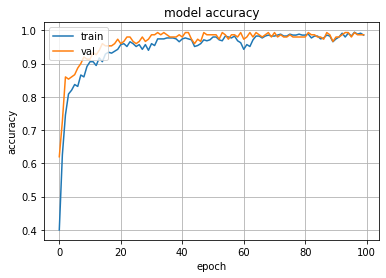

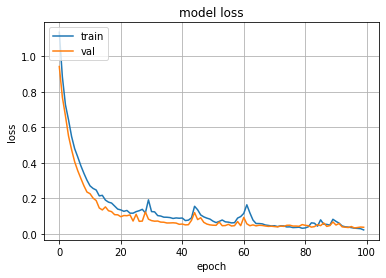

In [ ]:
nb_epoch=100

model = Sequential()

model.add(Bidirectional(LSTM(80, input_shape= (timesteps, data_dim), return_sequences = True)))
model.add(Dropout(0.1))

model.add(TimeDistributed(Dense(50)))

model.add(GlobalAveragePooling1D())

model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[sensitivity, specificity, 'accuracy'])
#print(model.summary())
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=64, epochs=nb_epoch)


plt.plot(history.history['specificity'], 'b--')
plt.plot(history.history['sensitivity'], 'g--')
plt.plot(history.history['accuracy'], 'r--')
plt.title('Model Different Metrics')
plt.ylabel('Metrics')
plt.xlabel('Epoch #')
plt.show()



scores = model.evaluate(X_test, y_test, verbose=0)
print("Sensitivity = %.2f%%" % (scores[1]*100))
print("Specificity = %.2f%%" % (scores[2]*100))
print("Classification Accuracy = %.2f%%" % (scores[3]*100))


%matplotlib inline
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

In [ ]:
#check output of model
y_predict=model.predict(X_test)

# define vector
probs = asarray(y_predict)
print(probs.shape)
# get argmax
result = argmax(probs, axis=1)
print(result)

y_test_cm=argmax(y_test,axis=1)
print(result.shape)



confusion = confusion_matrix(y_test_cm, result)
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test_cm, result)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test_cm, result, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test_cm, result, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test_cm, result, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test_cm, result, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test_cm, result, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test_cm, result, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test_cm, result, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test_cm, result, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_cm, result, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test_cm, result, target_names=['Class AB', 'Class CD', 'Class E']))

(150, 3)
[0 0 0 0 2 1 0 0 2 0 1 2 2 0 2 1 0 1 2 2 0 2 1 0 1 1 1 0 0 2 0 1 0 0 1 1 1
 2 2 1 1 0 1 2 0 2 0 1 1 0 2 2 2 2 2 0 1 1 1 1 0 0 2 1 0 1 1 2 2 0 1 2 1 1
 2 1 1 2 0 0 1 1 0 0 0 1 1 0 1 0 1 1 1 0 0 1 0 1 2 0 0 2 0 1 2 1 1 1 2 0 1
 1 0 0 0 1 0 0 0 2 0 2 0 0 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 2 0 0 0
 1 1]
(150,)
Confusion Matrix

[[60  0  0]
 [ 1 58  1]
 [ 0  0 30]]

Accuracy: 0.99

Micro Precision: 0.99
Micro Recall: 0.99
Micro F1-score: 0.99

Macro Precision: 0.98
Macro Recall: 0.99
Macro F1-score: 0.99

Weighted Precision: 0.99
Weighted Recall: 0.99
Weighted F1-score: 0.99

Classification Report

              precision    recall  f1-score   support

    Class AB       0.98      1.00      0.99        60
    Class CD       1.00      0.97      0.98        60
     Class E       0.97      1.00      0.98        30

    accuracy                           0.99       150
   macro avg       0.98      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



# [A.1] Saving frst model into drive

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/MyDrive/mtech_finalyr_project/3 class problem/model_3class_ABvsCDvsE.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/MyDrive/mtech_finalyr_project/3 class problem/model_3class_ABvsCDvsE.h5")
print("Saved model to disk")
 

Saved model to disk


# [A.2] loading frst model from drive

In [11]:
from keras.models import model_from_json

# load json and create model
json_file = open('/content/drive/MyDrive/mtech_finalyr_project/3 class problem/model_3class_ABvsCDvsE.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/mtech_finalyr_project/3 class problem/model_3class_ABvsCDvsE.h5")
print("Loaded model from disk")


Loaded model from disk


# [A.3] Evaluating Test-dataset(150*4096/2)with frst model

In [15]:
#dataset of size 150*(4096/2)
print("shape of X_test: ",X_test.shape)
df_2048=X_test[:,0:2048].copy()
print("shape of df_2048: ",df_2048.shape)


X_test_2048 = pd.concat([pd.DataFrame(df_2048), pd.DataFrame(df_2048)], axis=1,  ignore_index=True)
print("\nshape of df_2048: ",df_2048.shape)
print(df_2048)

X_test_2048=pd.DataFrame.to_numpy(X_test_2048)

X_test_2048 = X_test_2048.reshape([X_test_2048.shape[0], timesteps, data_dim])
y_test=np_utils.to_categorical(y_test, num_classes=3)



# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[sensitivity, specificity, 'accuracy'])
score = loaded_model.evaluate(X_test_2048,y_test, verbose=1)
print(" %.2f%%" % ( score[1]*100))

shape of X_test:  (150, 4096)
shape of df_2048:  (150, 2048)

shape of df_2048:  (150, 2048)
[[-53. -15.  11. ... -32. -64. -80.]
 [-42. -49. -37. ...  32.  23. -14.]
 [ 92. 110. 103. ...  48.  21.   5.]
 ...
 [-53. -33. -23. ... 103. 117. 107.]
 [-11.  -9. -11. ... -37. -36. -25.]
 [ 24.  19.  14. ... -12.  -8. -15.]]
5/5 [==============================] - 33s 77ms/step - loss: 0.0486 - sensitivity: 0.9716 - specificity: 0.9897 - accuracy: 0.9791
 98.12%


In [17]:
score

[0.039144616574048996,
 0.981249988079071,
 0.9937499761581421,
 0.9866666793823242]

# [A.4] Evaluating Test-dataset(150*4096/4)with frst model

In [22]:
#dataset of size 150*(1024)
print("shape of X_test: ",X_test.shape)
df_1024=X_test[:,0:1024].copy()
print("shape of df_1024: ",df_1024.shape)


X_test_1024 = pd.concat([pd.DataFrame(df_1024),pd.DataFrame(df_1024),pd.DataFrame(df_1024), pd.DataFrame(df_1024)], axis=1,  ignore_index=True)
print("\nshape of df_1024: ",df_1024.shape)
print(df_1024)

X_test_1024=pd.DataFrame.to_numpy(X_test_1024)

X_test_1024 = X_test_1024.reshape([X_test_1024.shape[0], timesteps, data_dim])
y_test=np_utils.to_categorical(y_test, num_classes=3)



# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[sensitivity, specificity, 'accuracy'])
score = loaded_model.evaluate(X_test_1024,y_test, verbose=1)
#print(" %.2f%%" % ( score[1]*100))

shape of X_test:  (150, 4096)
shape of df_1024:  (150, 1024)

shape of df_1024:  (150, 1024)
[[-53. -15.  11. ...  68.  87.  80.]
 [-42. -49. -37. ... 107.  56.  32.]
 [ 92. 110. 103. ... -29. -35. -41.]
 ...
 [-53. -33. -23. ... -71. -32.  -5.]
 [-11.  -9. -11. ... -16. -15. -20.]
 [ 24.  19.  14. ...   8.  18.  23.]]
5/5 [==============================] - 2s 79ms/step - loss: 0.0588 - sensitivity: 0.9923 - specificity: 0.9961 - accuracy: 0.9921


In [23]:
score

[0.05223961919546127,
 0.9937499761581421,
 0.996874988079071,
 0.9933333396911621]

# [A.5] Evaluating Test-dataset(150*4096/8)with frst model

In [29]:
#dataset of size 150*(512)
print("shape of X_test: ",X_test.shape)
df_512=X_test[:,0:512].copy()
print("shape of df_512: ",df_512.shape)


X_test_512 = pd.concat([pd.DataFrame(df_512),pd.DataFrame(df_512),pd.DataFrame(df_512), pd.DataFrame(df_512) , pd.DataFrame(df_512),pd.DataFrame(df_512),pd.DataFrame(df_512), pd.DataFrame(df_512)], axis=1,  ignore_index=True)
print("\nshape of df_512: ",df_512.shape)
print(df_512)

X_test_512=pd.DataFrame.to_numpy(X_test_512)

X_test_512 = X_test_512.reshape([X_test_512.shape[0], timesteps, data_dim])
#y_test=np_utils.to_categorical(y_test, num_classes=3)



# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[sensitivity, specificity, 'accuracy'])
score_512 = loaded_model.evaluate(X_test_512,y_test, verbose=1)
#print(" %.2f%%" % ( score[1]*100))

shape of X_test:  (150, 4096)
shape of df_512:  (150, 512)

shape of df_512:  (150, 512)
[[-53. -15.  11. ... -75. -80. -69.]
 [-42. -49. -37. ... -14.  28.  30.]
 [ 92. 110. 103. ...   7.  -1. -34.]
 ...
 [-53. -33. -23. ...  91.  25. -45.]
 [-11.  -9. -11. ... -20. -19. -17.]
 [ 24.  19.  14. ... -44. -36. -34.]]
5/5 [==============================] - 2s 78ms/step - loss: 0.0852 - sensitivity: 0.9635 - specificity: 0.9817 - accuracy: 0.9637


In [30]:
print(score)
print(score_512)

[0.081826351583004, 0.9659091234207153, 0.9829546213150024, 0.9666666388511658]
[0.081826351583004, 0.9659091234207153, 0.9829546213150024, 0.9666666388511658]


# (B) 3 class classification [A vs C vs E]

In [ ]:
df=pd.read_csv("/content/drive/My Drive/mtech_finalyr_project/modified_Dataset/final_csv_with_shuffle.csv")
df

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,4058,4059,4060,4061,4062,4063,4064,4065,4066,4067,4068,4069,4070,4071,4072,4073,4074,4075,4076,4077,4078,4079,4080,4081,4082,4083,4084,4085,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095,4096,tag
0,0,-18.0,-55.0,-126.0,-202.0,-238.0,-226.0,-171.0,-111.0,-73.0,-48.0,-45.0,-53.0,-95.0,-165.0,-243.0,-288.0,-309.0,-237.0,-95.0,163.0,528.0,899.0,1179.0,1316.0,1283.0,1132.0,907.0,672.0,338.0,-112.0,-340.0,-430.0,-38.0,293.0,379.0,178.0,-148.0,-375.0,-415.0,...,180.0,-125.0,48.0,204.0,747.0,1153.0,1183.0,949.0,534.0,153.0,-83.0,-168.0,-208.0,-250.0,-246.0,-235.0,-224.0,-244.0,-275.0,-305.0,-334.0,-368.0,-394.0,-406.0,-398.0,-361.0,-309.0,-225.0,-129.0,-59.0,-48.0,-94.0,-161.0,-210.0,-222.0,-224.0,-200.0,-127.0,-226.0,5
1,1,-26.0,1.0,29.0,41.0,33.0,2.0,-31.0,-60.0,-81.0,-99.0,-117.0,-140.0,-168.0,-200.0,-242.0,-280.0,-313.0,-339.0,-350.0,-345.0,-323.0,-292.0,-271.0,-269.0,-292.0,-354.0,-487.0,-682.0,-747.0,-635.0,-330.0,5.0,208.0,313.0,335.0,348.0,358.0,423.0,474.0,...,-423.0,-366.0,-229.0,-79.0,40.0,126.0,195.0,242.0,307.0,395.0,504.0,592.0,656.0,696.0,701.0,659.0,545.0,368.0,196.0,80.0,48.0,73.0,93.0,75.0,5.0,-101.0,-204.0,-279.0,-308.0,-288.0,-254.0,-220.0,-200.0,-201.0,-205.0,-209.0,-207.0,-210.0,-107.0,5
2,2,68.0,-106.0,-149.0,-141.0,-109.0,-69.0,-74.0,-93.0,-110.0,-103.0,-89.0,-72.0,-42.0,-18.0,5.0,24.0,50.0,74.0,93.0,110.0,118.0,120.0,118.0,118.0,114.0,108.0,100.0,88.0,71.0,57.0,39.0,20.0,7.0,10.0,40.0,95.0,173.0,240.0,239.0,...,244.0,364.0,262.0,-6.0,-319.0,-509.0,-501.0,-350.0,-150.0,-8.0,7.0,-30.0,-108.0,-183.0,-221.0,-182.0,-92.0,49.0,208.0,299.0,330.0,284.0,203.0,135.0,81.0,57.0,72.0,105.0,146.0,196.0,260.0,367.0,493.0,566.0,554.0,460.0,343.0,247.0,-468.0,5
3,3,343.0,311.0,284.0,274.0,260.0,237.0,165.0,-33.0,-271.0,-425.0,-418.0,-254.0,-104.0,-14.0,16.0,24.0,23.0,11.0,4.0,20.0,40.0,67.0,99.0,127.0,130.0,126.0,133.0,124.0,108.0,54.0,-5.0,-45.0,-61.0,-65.0,-52.0,-46.0,-25.0,-15.0,-4.0,...,-70.0,-118.0,-155.0,-201.0,-283.0,-368.0,-363.0,-333.0,-271.0,-203.0,-126.0,-31.0,48.0,86.0,102.0,124.0,125.0,132.0,144.0,187.0,263.0,343.0,411.0,433.0,417.0,397.0,395.0,414.0,435.0,439.0,428.0,423.0,430.0,472.0,515.0,527.0,480.0,397.0,217.0,5
4,4,-63.0,-107.0,-208.0,-310.0,-395.0,-491.0,-463.0,-426.0,-275.0,-114.0,34.0,142.0,191.0,183.0,141.0,103.0,76.0,66.0,74.0,95.0,110.0,127.0,136.0,141.0,141.0,137.0,118.0,89.0,42.0,6.0,-33.0,-52.0,-49.0,-31.0,-5.0,23.0,40.0,47.0,45.0,...,-588.0,-534.0,-475.0,-405.0,-330.0,-281.0,-269.0,-296.0,-358.0,-393.0,-363.0,-251.0,-131.0,-57.0,-81.0,-156.0,-239.0,-318.0,-396.0,-372.0,-270.0,-71.0,66.0,75.0,7.0,-84.0,-148.0,-187.0,-263.0,-367.0,-495.0,-517.0,-432.0,-234.0,-32.0,56.0,44.0,-37.0,28.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,213.0,210.0,210.0,212.0,194.0,162.0,121.0,84.0,45.0,11.0,-13.0,-20.0,-27.0,-32.0,-31.0,-39.0,-49.0,-61.0,-72.0,-80.0,-85.0,-87.0,-93.0,-96.0,-97.0,-94.0,-82.0,-57.0,-18.0,-3.0,-11.0,-1.0,41.0,120.0,181.0,202.0,198.0,195.0,197.0,...,-108.0,-112.0,-113.0,-112.0,-103.0,-100.0,-98.0,-95.0,-94.0,-92.0,-91.0,-89.0,-86.0,-84.0,-78.0,-70.0,-63.0,-53.0,-46.0,-37.0,-34.0,-29.0,-28.0,-23.0,-15.0,-13.0,-14.0,-9.0,-10.0,-5.0,-2.0,1.0,1.0,-2.0,-8.0,-9.0,-2.0,20.0,-231.0,5
496,496,24.0,10.0,-9.0,-18.0,-9.0,-3.0,-2.0,-2.0,-9.0,-9.0,-14.0,-14.0,-24.0,-24.0,-12.0,-1.0,13.0,31.0,60.0,79.0,98.0,110.0,104.0,72.0,40.0,26.0,24.0,33.0,40.0,29.0,13.0,3.0,2.0,0.0,10.0,32.0,52.0,61.0,54.0,...,55.0,33.0,15.0,-5.0,-18.0,-24.0,-28.0,-15.0,12.0,33.0,48.0,47.0,36.0,19.0,16.0,31.0,56.0,69.0,75.0,67.0,66.0,76.0,93.0,88.0,65.0,56.0,58.0,63.0,48.0,29.0,3.0,-17.0,-14.0,-21.0,-29.0,-39.0,-33.0,-28.0,-1

In [ ]:
print(df.columns)
df=df.drop(['Unnamed: 0'], axis = 1)
df=df.drop(['4096'], axis = 1)

#select only those record having 0 2 4 tags
df=df.loc[(df.tag== 1) | (df.tag == 3) | (df.tag == 5) ]
df

Index(['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '4088', '4089', '4090', '4091', '4092', '4093', '4094', '4095', '4096',
       'tag'],
      dtype='object', length=4099)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4057,4058,4059,4060,4061,4062,4063,4064,4065,4066,4067,4068,4069,4070,4071,4072,4073,4074,4075,4076,4077,4078,4079,4080,4081,4082,4083,4084,4085,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095,tag
0,-18.0,-55.0,-126.0,-202.0,-238.0,-226.0,-171.0,-111.0,-73.0,-48.0,-45.0,-53.0,-95.0,-165.0,-243.0,-288.0,-309.0,-237.0,-95.0,163.0,528.0,899.0,1179.0,1316.0,1283.0,1132.0,907.0,672.0,338.0,-112.0,-340.0,-430.0,-38.0,293.0,379.0,178.0,-148.0,-375.0,-415.0,-399.0,...,230.0,180.0,-125.0,48.0,204.0,747.0,1153.0,1183.0,949.0,534.0,153.0,-83.0,-168.0,-208.0,-250.0,-246.0,-235.0,-224.0,-244.0,-275.0,-305.0,-334.0,-368.0,-394.0,-406.0,-398.0,-361.0,-309.0,-225.0,-129.0,-59.0,-48.0,-94.0,-161.0,-210.0,-222.0,-224.0,-200.0,-127.0,5
1,-26.0,1.0,29.0,41.0,33.0,2.0,-31.0,-60.0,-81.0,-99.0,-117.0,-140.0,-168.0,-200.0,-242.0,-280.0,-313.0,-339.0,-350.0,-345.0,-323.0,-292.0,-271.0,-269.0,-292.0,-354.0,-487.0,-682.0,-747.0,-635.0,-330.0,5.0,208.0,313.0,335.0,348.0,358.0,423.0,474.0,456.0,...,-411.0,-423.0,-366.0,-229.0,-79.0,40.0,126.0,195.0,242.0,307.0,395.0,504.0,592.0,656.0,696.0,701.0,659.0,545.0,368.0,196.0,80.0,48.0,73.0,93.0,75.0,5.0,-101.0,-204.0,-279.0,-308.0,-288.0,-254.0,-220.0,-200.0,-201.0,-205.0,-209.0,-207.0,-210.0,5
2,68.0,-106.0,-149.0,-141.0,-109.0,-69.0,-74.0,-93.0,-110.0,-103.0,-89.0,-72.0,-42.0,-18.0,5.0,24.0,50.0,74.0,93.0,110.0,118.0,120.0,118.0,118.0,114.0,108.0,100.0,88.0,71.0,57.0,39.0,20.0,7.0,10.0,40.0,95.0,173.0,240.0,239.0,164.0,...,-30.0,244.0,364.0,262.0,-6.0,-319.0,-509.0,-501.0,-350.0,-150.0,-8.0,7.0,-30.0,-108.0,-183.0,-221.0,-182.0,-92.0,49.0,208.0,299.0,330.0,284.0,203.0,135.0,81.0,57.0,72.0,105.0,146.0,196.0,260.0,367.0,493.0,566.0,554.0,460.0,343.0,247.0,5
3,343.0,311.0,284.0,274.0,260.0,237.0,165.0,-33.0,-271.0,-425.0,-418.0,-254.0,-104.0,-14.0,16.0,24.0,23.0,11.0,4.0,20.0,40.0,67.0,99.0,127.0,130.0,126.0,133.0,124.0,108.0,54.0,-5.0,-45.0,-61.0,-65.0,-52.0,-46.0,-25.0,-15.0,-4.0,-12.0,...,2.0,-70.0,-118.0,-155.0,-201.0,-283.0,-368.0,-363.0,-333.0,-271.0,-203.0,-126.0,-31.0,48.0,86.0,102.0,124.0,125.0,132.0,144.0,187.0,263.0,343.0,411.0,433.0,417.0,397.0,395.0,414.0,435.0,439.0,428.0,423.0,430.0,472.0,515.0,527.0,480.0,397.0,5
4,-63.0,-107.0,-208.0,-310.0,-395.0,-491.0,-463.0,-426.0,-275.0,-114.0,34.0,142.0,191.0,183.0,141.0,103.0,76.0,66.0,74.0,95.0,110.0,127.0,136.0,141.0,141.0,137.0,118.0,89.0,42.0,6.0,-33.0,-52.0,-49.0,-31.0,-5.0,23.0,40.0,47.0,45.0,40.0,...,-616.0,-588.0,-534.0,-475.0,-405.0,-330.0,-281.0,-269.0,-296.0,-358.0,-393.0,-363.0,-251.0,-131.0,-57.0,-81.0,-156.0,-239.0,-318.0,-396.0,-372.0,-270.0,-71.0,66.0,75.0,7.0,-84.0,-148.0,-187.0,-263.0,-367.0,-495.0,-517.0,-432.0,-234.0,-32.0,56.0,44.0,-37.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,213.0,210.0,210.0,212.0,194.0,162.0,121.0,84.0,45.0,11.0,-13.0,-20.0,-27.0,-32.0,-31.0,-39.0,-49.0,-61.0,-72.0,-80.0,-85.0,-87.0,-93.0,-96.0,-97.0,-94.0,-82.0,-57.0,-18.0,-3.0,-11.0,-1.0,41.0,120.0,181.0,202.0,198.0,195.0,197.0,190.0,...,-110.0,-108.0,-112.0,-113.0,-112.0,-103.0,-100.0,-98.0,-95.0,-94.0,-92.0,-91.0,-89.0,-86.0,-84.0,-78.0,-70.0,-63.0,-53.0,-46.0,-37.0,-34.0,-29.0,-28.0,-23.0,-15.0,-13.0,-14.0,-9.0,-10.0,-5.0,-2.0,1.0,1.0,-2.0,-8.0,-9.0,-2.0,20.0,5
496,24.0,10.0,-9.0,-18.0,-9.0,-3.0,-2.0,-2.0,-9.0,-9.0,-14.0,-14.0,-24.0,-24.0,-12.0,-1.0,13.0,31.0,60.0,79.0,98.0,110.0,104.0,72.0,40.0,26.0,24.0,33.0,40.0,29.0,13.0,3.0,2.0,0.0,10.0,32.0,52.0,61.0,54.0,19.0,...,73.0,55.0,33.0,15.0,-5.0,-18.0,-24.0,-28.0,-15.0,12.0,33.0,48.0,47.0,36.0,19.0,16.0,31.0,56.0,69.0,75.0,67.0,66.0,76.0,93.0,88.0,65.0,56.0,58.0,63.0,48.0,29.0,3.0,-17.0,-14.0,-21.0,-29.0,-3

In [ ]:
print(df.shape)
df["tag"].value_counts()

(300, 4097)


5    100
3    100
1    100
Name: tag, dtype: int64

In [ ]:
df.tag=df.tag.replace({ 1:0 , 3:1 , 5:2 })
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4057,4058,4059,4060,4061,4062,4063,4064,4065,4066,4067,4068,4069,4070,4071,4072,4073,4074,4075,4076,4077,4078,4079,4080,4081,4082,4083,4084,4085,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095,tag
0,-18.0,-55.0,-126.0,-202.0,-238.0,-226.0,-171.0,-111.0,-73.0,-48.0,-45.0,-53.0,-95.0,-165.0,-243.0,-288.0,-309.0,-237.0,-95.0,163.0,528.0,899.0,1179.0,1316.0,1283.0,1132.0,907.0,672.0,338.0,-112.0,-340.0,-430.0,-38.0,293.0,379.0,178.0,-148.0,-375.0,-415.0,-399.0,...,230.0,180.0,-125.0,48.0,204.0,747.0,1153.0,1183.0,949.0,534.0,153.0,-83.0,-168.0,-208.0,-250.0,-246.0,-235.0,-224.0,-244.0,-275.0,-305.0,-334.0,-368.0,-394.0,-406.0,-398.0,-361.0,-309.0,-225.0,-129.0,-59.0,-48.0,-94.0,-161.0,-210.0,-222.0,-224.0,-200.0,-127.0,2
1,-26.0,1.0,29.0,41.0,33.0,2.0,-31.0,-60.0,-81.0,-99.0,-117.0,-140.0,-168.0,-200.0,-242.0,-280.0,-313.0,-339.0,-350.0,-345.0,-323.0,-292.0,-271.0,-269.0,-292.0,-354.0,-487.0,-682.0,-747.0,-635.0,-330.0,5.0,208.0,313.0,335.0,348.0,358.0,423.0,474.0,456.0,...,-411.0,-423.0,-366.0,-229.0,-79.0,40.0,126.0,195.0,242.0,307.0,395.0,504.0,592.0,656.0,696.0,701.0,659.0,545.0,368.0,196.0,80.0,48.0,73.0,93.0,75.0,5.0,-101.0,-204.0,-279.0,-308.0,-288.0,-254.0,-220.0,-200.0,-201.0,-205.0,-209.0,-207.0,-210.0,2
2,68.0,-106.0,-149.0,-141.0,-109.0,-69.0,-74.0,-93.0,-110.0,-103.0,-89.0,-72.0,-42.0,-18.0,5.0,24.0,50.0,74.0,93.0,110.0,118.0,120.0,118.0,118.0,114.0,108.0,100.0,88.0,71.0,57.0,39.0,20.0,7.0,10.0,40.0,95.0,173.0,240.0,239.0,164.0,...,-30.0,244.0,364.0,262.0,-6.0,-319.0,-509.0,-501.0,-350.0,-150.0,-8.0,7.0,-30.0,-108.0,-183.0,-221.0,-182.0,-92.0,49.0,208.0,299.0,330.0,284.0,203.0,135.0,81.0,57.0,72.0,105.0,146.0,196.0,260.0,367.0,493.0,566.0,554.0,460.0,343.0,247.0,2
3,343.0,311.0,284.0,274.0,260.0,237.0,165.0,-33.0,-271.0,-425.0,-418.0,-254.0,-104.0,-14.0,16.0,24.0,23.0,11.0,4.0,20.0,40.0,67.0,99.0,127.0,130.0,126.0,133.0,124.0,108.0,54.0,-5.0,-45.0,-61.0,-65.0,-52.0,-46.0,-25.0,-15.0,-4.0,-12.0,...,2.0,-70.0,-118.0,-155.0,-201.0,-283.0,-368.0,-363.0,-333.0,-271.0,-203.0,-126.0,-31.0,48.0,86.0,102.0,124.0,125.0,132.0,144.0,187.0,263.0,343.0,411.0,433.0,417.0,397.0,395.0,414.0,435.0,439.0,428.0,423.0,430.0,472.0,515.0,527.0,480.0,397.0,2
4,-63.0,-107.0,-208.0,-310.0,-395.0,-491.0,-463.0,-426.0,-275.0,-114.0,34.0,142.0,191.0,183.0,141.0,103.0,76.0,66.0,74.0,95.0,110.0,127.0,136.0,141.0,141.0,137.0,118.0,89.0,42.0,6.0,-33.0,-52.0,-49.0,-31.0,-5.0,23.0,40.0,47.0,45.0,40.0,...,-616.0,-588.0,-534.0,-475.0,-405.0,-330.0,-281.0,-269.0,-296.0,-358.0,-393.0,-363.0,-251.0,-131.0,-57.0,-81.0,-156.0,-239.0,-318.0,-396.0,-372.0,-270.0,-71.0,66.0,75.0,7.0,-84.0,-148.0,-187.0,-263.0,-367.0,-495.0,-517.0,-432.0,-234.0,-32.0,56.0,44.0,-37.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,213.0,210.0,210.0,212.0,194.0,162.0,121.0,84.0,45.0,11.0,-13.0,-20.0,-27.0,-32.0,-31.0,-39.0,-49.0,-61.0,-72.0,-80.0,-85.0,-87.0,-93.0,-96.0,-97.0,-94.0,-82.0,-57.0,-18.0,-3.0,-11.0,-1.0,41.0,120.0,181.0,202.0,198.0,195.0,197.0,190.0,...,-110.0,-108.0,-112.0,-113.0,-112.0,-103.0,-100.0,-98.0,-95.0,-94.0,-92.0,-91.0,-89.0,-86.0,-84.0,-78.0,-70.0,-63.0,-53.0,-46.0,-37.0,-34.0,-29.0,-28.0,-23.0,-15.0,-13.0,-14.0,-9.0,-10.0,-5.0,-2.0,1.0,1.0,-2.0,-8.0,-9.0,-2.0,20.0,2
496,24.0,10.0,-9.0,-18.0,-9.0,-3.0,-2.0,-2.0,-9.0,-9.0,-14.0,-14.0,-24.0,-24.0,-12.0,-1.0,13.0,31.0,60.0,79.0,98.0,110.0,104.0,72.0,40.0,26.0,24.0,33.0,40.0,29.0,13.0,3.0,2.0,0.0,10.0,32.0,52.0,61.0,54.0,19.0,...,73.0,55.0,33.0,15.0,-5.0,-18.0,-24.0,-28.0,-15.0,12.0,33.0,48.0,47.0,36.0,19.0,16.0,31.0,56.0,69.0,75.0,67.0,66.0,76.0,93.0,88.0,65.0,56.0,58.0,63.0,48.0,29.0,3.0,-17.0,-14.0,-21.0,-29.0,-3

In [ ]:
df["tag"].value_counts()

2    100
1    100
0    100
Name: tag, dtype: int64

In [ ]:
# Time Steps of LSTM
data_length = 4096
timesteps = 2048
data_dim = data_length//timesteps
data_dim


#breaking dataset into X nd y
df1=df.values     #df1 is numpy.ndarray and df is pandas.dataframe
X, y = df1[:, :-1], df1[:, -1]
print(df.shape)
print("shape of X",X.shape)
print("shape of y",y.shape)


#breaking X nd y into train nd test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1, stratify=y)

print("\nshape of X_train",X_train.shape)
print("shape of X_test",X_test.shape)
print("shape of y_train",y_train.shape)
print("shape of y_test",y_test.shape)

X_train=X_train.reshape([X_train.shape[0], timesteps, data_dim])
X_test = X_test.reshape([X_test.shape[0], timesteps, data_dim])
y_train=np_utils.to_categorical(y_train, num_classes=3)
y_test=np_utils.to_categorical(y_test, num_classes=3)



print("\nshape of X_train",X_train.shape)
print("shape of X_test",X_test.shape)
print("shape of y_train",y_train.shape)
print("shape of y_test",y_test.shape)

(300, 4097)
shape of X (300, 4096)
shape of y (300,)

shape of X_train (210, 4096)
shape of X_test (90, 4096)
shape of y_train (210,)
shape of y_test (90,)

shape of X_train (210, 2048, 2)
shape of X_test (90, 2048, 2)
shape of y_train (210, 3)
shape of y_test (90, 3)


Epoch 1/100
4/4 [==============================] - 5s 423ms/step - loss: 1.0586 - sensitivity: 0.0108 - specificity: 0.9946 - accuracy: 0.4297 - val_loss: 0.8748 - val_sensitivity: 0.1004 - val_specificity: 1.0000 - val_accuracy: 0.8778
Epoch 2/100
4/4 [==============================] - 1s 177ms/step - loss: 0.8447 - sensitivity: 0.2481 - specificity: 0.9878 - accuracy: 0.8160 - val_loss: 0.7362 - val_sensitivity: 0.4922 - val_specificity: 0.9865 - val_accuracy: 0.6778
Epoch 3/100
4/4 [==============================] - 1s 177ms/step - loss: 0.7265 - sensitivity: 0.4944 - specificity: 0.9678 - accuracy: 0.6833 - val_loss: 0.6295 - val_sensitivity: 0.5042 - val_specificity: 0.9826 - val_accuracy: 0.8333
Epoch 4/100
4/4 [==============================] - 1s 178ms/step - loss: 0.6258 - sensitivity: 0.5089 - specificity: 0.9772 - accuracy: 0.8314 - val_loss: 0.5511 - val_sensitivity: 0.6238 - val_specificity: 0.9691 - val_accuracy: 0.9111
Epoch 5/100
4/4 [==============================] - 1

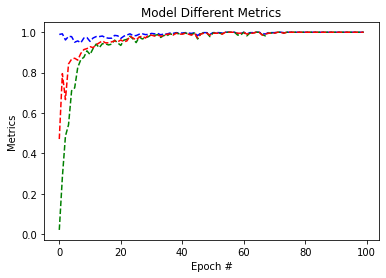

Sensitivity = 97.44%
Specificity = 98.72%
Classification Accuracy = 97.78%


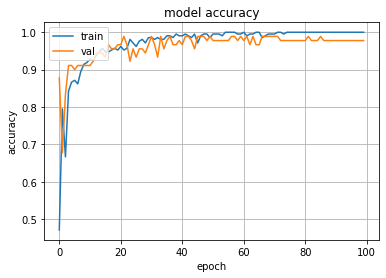

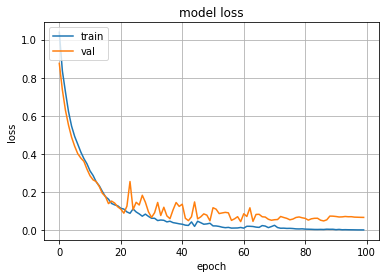

In [ ]:
nb_epoch=100

model = Sequential()

model.add(Bidirectional(LSTM(80, input_shape= (timesteps, data_dim), return_sequences = True)))
model.add(Dropout(0.1))

model.add(TimeDistributed(Dense(50)))

model.add(GlobalAveragePooling1D())

model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[sensitivity, specificity, 'accuracy'])
#print(model.summary())
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=64, epochs=nb_epoch)


plt.plot(history.history['specificity'], 'b--')
plt.plot(history.history['sensitivity'], 'g--')
plt.plot(history.history['accuracy'], 'r--')
plt.title('Model Different Metrics')
plt.ylabel('Metrics')
plt.xlabel('Epoch #')
plt.show()



scores = model.evaluate(X_test, y_test, verbose=0)
print("Sensitivity = %.2f%%" % (scores[1]*100))
print("Specificity = %.2f%%" % (scores[2]*100))
print("Classification Accuracy = %.2f%%" % (scores[3]*100))


%matplotlib inline
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

In [ ]:
#check output of model
y_predict=model.predict(X_test)

# define vector
probs = asarray(y_predict)
print(probs.shape)
# get argmax
result = argmax(probs, axis=1)
print(result)

y_test_cm=argmax(y_test,axis=1)
print(result.shape)



confusion = confusion_matrix(y_test_cm, result)
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test_cm, result)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test_cm, result, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test_cm, result, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test_cm, result, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test_cm, result, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test_cm, result, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test_cm, result, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test_cm, result, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test_cm, result, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_cm, result, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test_cm, result, target_names=['Class A', 'Class C', 'Class E']))

(90, 3)
[2 2 0 0 0 1 1 1 2 0 0 0 2 1 0 2 0 0 1 0 2 1 0 2 2 1 0 0 2 1 2 1 1 2 0 2 1
 1 1 0 1 1 2 0 0 1 2 0 2 1 2 2 1 1 2 0 2 1 0 1 2 0 1 0 0 2 2 2 0 2 1 2 0 2
 0 1 1 1 2 1 0 1 2 0 2 0 0 2 2 0]
(90,)
Confusion Matrix

[[30  0  0]
 [ 1 28  1]
 [ 0  0 30]]

Accuracy: 0.98

Micro Precision: 0.98
Micro Recall: 0.98
Micro F1-score: 0.98

Macro Precision: 0.98
Macro Recall: 0.98
Macro F1-score: 0.98

Weighted Precision: 0.98
Weighted Recall: 0.98
Weighted F1-score: 0.98

Classification Report

              precision    recall  f1-score   support

     Class A       0.97      1.00      0.98        30
     Class C       1.00      0.93      0.97        30
     Class E       0.97      1.00      0.98        30

    accuracy                           0.98        90
   macro avg       0.98      0.98      0.98        90
weighted avg       0.98      0.98      0.98        90



In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/MyDrive/mtech_finalyr_project/3 class problem/model_3class_AvsCvsE.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/MyDrive/mtech_finalyr_project/3 class problem/model_3class_AvsCvsE.h5")
print("Saved model to disk")
 

Saved model to disk


In [ ]:
"""
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
"""